In [7]:
import pandas as pd
import re
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sts
import math
import xlrd
from sklearn import metrics
from statannot import add_stat_annotation
from collections import Counter
import pickle
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from os import listdir
from os.path import isfile
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import networkx as nx
import pickle
import joblib
from matplotlib_venn import venn3

In [8]:
Cancer=['BRCA','CCRCC','COAD','GBM','HCC','HNSCC','LSCC','LUAD','OV','PDAC','UCEC'] 

In [9]:
kinases_id=pd.read_excel('KSA/kinase_table.xlsx')
kinases_id.index=kinases_id.Name
K_S_GPS=pd.read_csv('KSA/KSA_gold_standard.csv',index_col=0)

In [10]:
ks=list(set(K_S_GPS['Gene name']))

In [11]:
poor_kinase=[]
mid_kinase=[]
rich_kinase=[]
other_kinase=[]
poor_num=[]
mid_num=[]
rich_num=[]
other_num=[]
for i in ks:
    if 'family' not in i:
        if 'Isoform' not in i:
            tmp=K_S_GPS[K_S_GPS['Gene name']==i]
            if len(set(tmp['seq_15']))<=10:
                poor_kinase.append(i)
                poor_num.append(len(set(tmp['seq_15'])))
            if len(set(tmp['seq_15']))>10 and len(set(tmp['seq_15']))<=20:
                mid_kinase.append(i)
                mid_num.append(len(set(tmp['seq_15'])))
            if len(set(tmp['seq_15']))>20:
                rich_kinase.append(i)
                rich_num.append(len(set(tmp['seq_15'])))
            if len(set(tmp['seq_15']))>10:
                other_kinase.append(i)
                other_num.append(len(set(tmp['seq_15'])))

In [12]:
len(K_S_GPS[K_S_GPS['Gene name'].isin(rich_kinase)])/len(K_S_GPS)

0.8745146127120376

In [13]:
#CoPheeMap
network=pd.read_csv('CoPheeMap/data_construction/model_all_pos/All_positive_thred_9679.csv',index_col=0)
seq1=[i.split('|')[3] for i in network.index.tolist()]
seq2=[i.split('|')[3] for i in network.site2.tolist()]
network['seq1']=np.array(seq1)
network['seq2']=np.array(seq2)
sites=list(set(network.index.tolist()+network.site2.tolist()))
G = nx.Graph()
elist=list(zip(network.index.tolist(),network.site2.tolist()))
G.add_edges_from(elist)

idx_ST=[]
idx_Y=[]
for i in range(len(network)):
    if network.seq1.iloc[i][7] in ['S','T']:
        idx_ST.append(i)
    if network.seq1.iloc[i][7] in ['Y']:
        idx_Y.append(i)
network_ST=network.iloc[idx_ST,:]
network_Y=network.iloc[idx_Y,:]
lst_ST=list(set(network_ST.index.tolist()+network_ST.site2.tolist()))
H=G.subgraph(lst_ST)
nodes_ST=max(nx.connected_components(H))
G_ST=G.subgraph(nodes_ST)
network_Y=network.iloc[idx_Y,:]
lst_Y=list(set(network_Y.index.tolist()+network_Y.site2.tolist()))
H=G.subgraph(lst_Y)
nodes_Y=max(nx.connected_components(H))
G_Y=G.subgraph(nodes_Y)

In [14]:
len(nodes_ST)

25028

In [15]:
len(nodes_Y)

110

In [13]:
kk_emb=pd.read_csv('CoPheeKSA/kinase_network/n2v_KK_PPI_PCC.csv',index_col=0)
cophee_emb=pd.read_csv('CoPheeMap/data_construction/model_all_pos/n2v_networkST.csv', index_col=0)

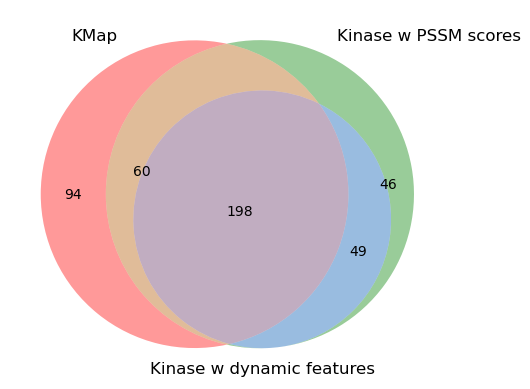

In [15]:
#kinase coverage
#kinase network
k_list1=kk_emb.index.tolist()
mypath='CoPheeKSA/dynamic_features/all_data_for_kinase/'
onlyfiles = [f for f in listdir(mypath) if f!='.DS_Store']
k_list2=[i.split('_')[0] for i in onlyfiles]
mypath='CoPheeKSA/static_features/all'
onlyfiles = [f for f in listdir(mypath) if f!='.DS_Store']
k_list3=[i.split('_')[0] for i in onlyfiles]
v=venn3(subsets = [set(k_list1), set(k_list2), set(k_list3)], 
        set_labels = ( 'KMap','Kinase w PSSM scores', 'Kinase w dynamic features'))
plt.savefig('CoPheeKSA/figures/kinase_coverage.jpeg',bbox_inches='tight',dpi=300,pad_inches=0.1,orientation='portrait')
plt.show()

#Negative KSA
#sites regulated by kinases belong to different groups
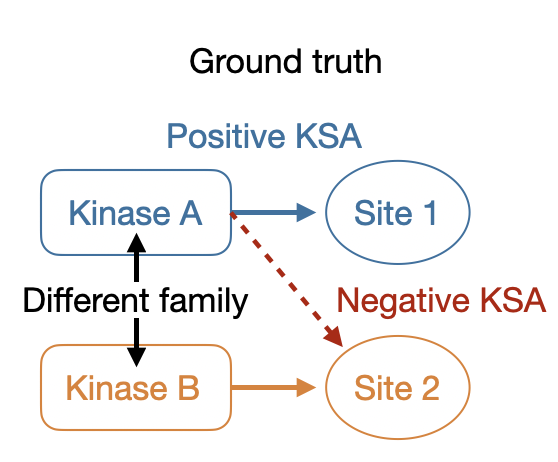

In [ ]:
#Construct positive and negative KSAs
nd_ST=list(G_ST.nodes)
#positive KSAs
df=pd.DataFrame()
df['nodes']=list(nd_ST)
df['seq']=[i.split('|')[3] for i in list(nd_ST)]

kinases=[]
pos_sites_combined=[]
for i in range(len(K_S_GPS)):
    seq=K_S_GPS.seq_15.iloc[i]
    tmp=df[df['seq'].isin([seq])]
    if len(tmp)>0:
        pos_sites_combined.append(tmp.nodes.iloc[0])
        kinases.append(K_S_GPS['Gene name'].iloc[i])
KSA_pos=pd.DataFrame()
KSA_pos['sites']=pos_sites_combined
KSA_pos['kinases']=kinases
KSA_pos=KSA_pos.drop_duplicates()
KSA_pos.index=range(len(KSA_pos))

combined_cancer_neg=pd.read_csv('CoPheeMap/data_construction/gold_standard_site_pairs/combined_cancer_neg.csv',index_col=0)

#nagative KSAs for ST network

Site1=[i.split('*')[0] for i in combined_cancer_neg.index]
Site2=[i.split('*')[1] for i in combined_cancer_neg.index]
seq1=[i.split('|')[3] for i in Site1]
seq2=[i.split('|')[3] for i in Site2]
combined_cancer_neg['site1']=np.array(Site1)
combined_cancer_neg['site2']=np.array(Site2)
combined_cancer_neg['seq1']=np.array(seq1)
combined_cancer_neg['seq2']=np.array(seq2)

tmp_neg=combined_cancer_neg[combined_cancer_neg.site1.isin(nd_ST)]
tmp_neg=tmp_neg[tmp_neg.site2.isin(nd_ST)]

ks=list(set(K_S_GPS['Gene name']))
kinases=np.array([])
neg_sites_combined=[]
for k in ks:
    tmp_KS=K_S_GPS[K_S_GPS['Gene name']==k]
    seqs=tmp_KS.seq_15.tolist()
    tmp1=tmp_neg[tmp_neg['seq1'].isin(seqs)]
    tmp1=tmp1[~tmp1['seq2'].isin(seqs)]
    tmp2=tmp_neg[tmp_neg['seq2'].isin(seqs)]
    tmp2=tmp2[~tmp2['seq2'].isin(seqs)]
    neg_sites=list(set(tmp1.site2.tolist()+tmp2.site1.tolist()))
    kinases=np.concatenate((kinases,np.repeat(k,len(neg_sites))))
    neg_sites_combined=neg_sites_combined+neg_sites
KSA_neg=pd.DataFrame()
KSA_neg['sites']=neg_sites_combined
KSA_neg['kinases']=kinases
KSA_neg=KSA_neg.drop_duplicates()
KSA_neg.index=range(len(KSA_neg))
#KSA_neg.to_csv('CoPheeKSA/negative_KSA.csv')
#KSA_pos.to_csv('CoPheeKSA/positive_KSA.csv')

In [53]:
KSA_pos=pd.read_csv('CoPheeKSA/positive_KSA.csv',index_col=0)
KSA_neg=pd.read_csv('CoPheeKSA/negative_KSA.csv',index_col=0)

In [51]:
#10 fold test
#for i in range(10):
#    idx=random.sample(range(len(KSA_pos)),235)
#    test=KSA_pos.iloc[idx]
#    test.to_csv('CoPheeKSA/test/test_'+str(i)+'.csv')
#    train=KSA_pos[~KSA_pos.index.isin(idx)]
#    train.to_csv('CoPheeKSA/train/train_'+str(i)+'.csv')

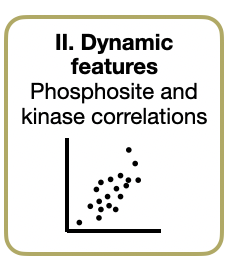

In [12]:
#Import PanCan datasets
#Phospho
BRCA_tumor=pd.read_table('PanCan/Phospho/BRCA_phospho_site_abundance_log2_reference_intensity_normalized_isoform_adjusted_Tumor.cct',index_col='idx')
CCRCC_tumor=pd.read_table('PanCan/Phospho/CCRCC_phospho_site_abundance_log2_reference_intensity_normalized_isoform_adjusted_Tumor.cct',index_col='idx')
COAD_tumor=pd.read_table('PanCan/Phospho/COAD_phospho_site_abundance_log2_reference_intensity_normalized_isoform_adjusted_Tumor.cct',index_col='idx')
GBM_tumor=pd.read_table('PanCan/Phospho/GBM_phospho_site_abundance_log2_reference_intensity_normalized_isoform_adjusted_Tumor.cct',index_col='idx')
HCC_tumor=pd.read_table('PanCan/Phospho/HCC_phospho_site_abundance_log2_reference_intensity_normalized_isoform_adjusted_Tumor.cct',index_col='idx')
HNSCC_tumor=pd.read_table('PanCan/Phospho/HNSCC_phospho_site_abundance_log2_reference_intensity_normalized_isoform_adjusted_Tumor.cct',index_col='idx')
LSCC_tumor=pd.read_table('PanCan/Phospho/LSCC_phospho_site_abundance_log2_reference_intensity_normalized_isoform_adjusted_Tumor.cct',index_col='idx')
LUAD_tumor=pd.read_table('PanCan/Phospho/LUAD_phospho_site_abundance_log2_reference_intensity_normalized_isoform_adjusted_Tumor.cct',index_col='idx')
OV_tumor=pd.read_table('PanCan/Phospho/OV_phospho_site_abundance_log2_reference_intensity_normalized_isoform_adjusted_Tumor.cct',index_col='idx')
PDAC_tumor=pd.read_table('PanCan/Phospho/PDAC_phospho_site_abundance_log2_reference_intensity_normalized_isoform_adjusted_Tumor.cct',index_col='idx')
UCEC_tumor=pd.read_table('PanCan/Phospho/UCEC_phospho_site_abundance_log2_reference_intensity_normalized_isoform_adjusted_Tumor.cct',index_col='idx')

In [13]:
tmp_new=[]
tmp=[BRCA_tumor,CCRCC_tumor,COAD_tumor,GBM_tumor,HCC_tumor,HNSCC_tumor,
     LSCC_tumor,LUAD_tumor,OV_tumor,PDAC_tumor,UCEC_tumor]
for d in range(len(tmp)):
    DATA=tmp[d]
    ks=[]
    DATA.replace([np.inf, -np.inf], np.nan, inplace=True)
    idx_80=[]
    for k in range(len(DATA)):
        if sum(DATA.iloc[k,:].isna())/len(DATA.iloc[0,:])<=0.8:
            idx_80.append(k)
    DATA=DATA.iloc[idx_80,:]
    tmp_new.append(DATA)
for i in range(len(tmp_new)):
    tmp=tmp_new[i]
    seq_15=[k.split('|')[3] for k in tmp.index]
    tmp['seq_15']=np.array(seq_15)
    tmp_new[i]=tmp

/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_99693/3957516920.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['seq_15']=np.array(seq_15)
/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_99693/3957516920.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['seq_15']=np.array(seq_15)
/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_99693/3957516920.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

In [14]:
tmp_new_median=[]
tmp=[BRCA_tumor,CCRCC_tumor,COAD_tumor,GBM_tumor,HCC_tumor,HNSCC_tumor,
     LSCC_tumor,LUAD_tumor,OV_tumor,PDAC_tumor,UCEC_tumor]
for d in range(len(tmp)):
    DATA=tmp[d]
    DATA = DATA.apply(lambda col: col -col.median())
    ks=[]
    DATA.replace([np.inf, -np.inf], np.nan, inplace=True)
    idx_80=[]
    for k in range(len(DATA)):
        if sum(DATA.iloc[k,:].isna())/len(DATA.iloc[0,:])<=0.8:
            idx_80.append(k)
    DATA=DATA.iloc[idx_80,:]
    tmp_new_median.append(DATA)
for i in range(len(tmp_new_median)):
    tmp=tmp_new_median[i]
    seq_15=[k.split('|')[3] for k in tmp.index]
    tmp['seq_15']=np.array(seq_15)
    tmp_new_median[i]=tmp

In [15]:
ks=list(set(K_S_GPS['Gene name']))

In [75]:
#Kinase activity for each cancer type
Cancer=['BRCA','CCRCC','COAD','GBM','HCC','HNSCC','LSCC','LUAD','OV','PDAC','UCEC']
for i in range(len(tmp_new_median)):
    print(i)
    kinase_activity_mean={}
    kinase_activity_median={}
    for k in ks:
        tmp=K_S_GPS[K_S_GPS['Gene name']==k]
        seq_lst=tmp['seq_15'].tolist()
        data=tmp_new_median[i]
        data=data[data.seq_15.isin(seq_lst)]
        #At least 3 substrates quantified
        acc=[]
        for l in range(len(data.columns)-1):
            tmp=data.iloc[:,[l]]
            tmp=tmp[~tmp.isna()]
            if len(tmp)>=3:
                acc.append(tmp.mean()[0])
            else:
                acc.append(np.nan)
        kinase_activity_mean[k]=acc
    name=''.join(['CoPheeKSA/kinase_activity/without_median/',Cancer[i],'_ka_mean.csv'])
    kinase_activity_mean=pd.DataFrame(kinase_activity_mean)
    kinase_activity_mean=kinase_activity_mean.transpose()
    kinase_activity_mean.columns=data.columns[:-1]
    kinase_activity_mean.to_csv(name)

0
1
2
3
4
5
6
7
8
9
10


In [26]:
nd_ST=list(G_ST.nodes)
#Cancer type site-kinase-activity-spc
Cancer=['BRCA','CCRCC','COAD','GBM','HCC','HNSCC','LSCC','LUAD','OV','PDAC','UCEC']
BRCA_activity=pd.read_csv('CoPheeKSA/kinase_activity/without_median/BRCA_ka_mean.csv',index_col=0)
CCRCC_activity=pd.read_csv('CoPheeKSA/kinase_activity/without_median/CCRCC_ka_mean.csv',index_col=0)
COAD_activity=pd.read_csv('CoPheeKSA/kinase_activity/without_median/COAD_ka_mean.csv',index_col=0)
GBM_activity=pd.read_csv('CoPheeKSA/kinase_activity/without_median/GBM_ka_mean.csv',index_col=0)
HCC_activity=pd.read_csv('CoPheeKSA/kinase_activity/without_median/HCC_ka_mean.csv',index_col=0)
HNSCC_activity=pd.read_csv('CoPheeKSA/kinase_activity/without_median/HNSCC_ka_mean.csv',index_col=0)
LSCC_activity=pd.read_csv('CoPheeKSA/kinase_activity/without_median/LSCC_ka_mean.csv',index_col=0)
LUAD_activity=pd.read_csv('CoPheeKSA/kinase_activity/without_median/LUAD_ka_mean.csv',index_col=0)
OV_activity=pd.read_csv('CoPheeKSA/kinase_activity/without_median/OV_ka_mean.csv',index_col=0)
PDAC_activity=pd.read_csv('CoPheeKSA/kinase_activity/without_median/PDAC_ka_mean.csv',index_col=0)
UCEC_activity=pd.read_csv('CoPheeKSA/kinase_activity/without_median/UCEC_ka_mean.csv',index_col=0)
activities=[BRCA_activity,CCRCC_activity,COAD_activity,GBM_activity,HCC_activity,HNSCC_activity,
            LSCC_activity,LUAD_activity,OV_activity,PDAC_activity,UCEC_activity]

for i in range(len(activities)):
    print(i)
    k_s_features={}
    data_pro=activities[i]
    gene_lst=data_pro.index.tolist()
    data_site=tmp_new_median[i]
    data_site=data_site[data_site.index.isin(nd_ST)]
    sample=list(set(data_pro.columns).intersection(set(data_site.columns)))
    data_site=data_site[sample]
    data_pro=data_pro[sample]
    for k in range(len(data_pro)):
        gene_id=gene_lst[k]
        b_abundance=data_pro.iloc[k,:]
        if b_abundance.isna().sum()==len(data_pro.columns):
            k_s_features[gene_id]=np.repeat(np.nan,len(data_site))
        else:
            pro_k_pcc=[]
            for s in range(len(data_site)):
                a_abundance=data_site.iloc[s,:]
                nas = np.logical_or(a_abundance.isna(), b_abundance.isna())
                a_bundance_filtered=a_abundance[~nas]
                b_abundance_filtered=b_abundance[~nas]
                if len(a_abundance)>=20:
                    try:
                        corr = sts.spearmanr(a_bundance_filtered, b_abundance_filtered,nan_policy='omit')
                        pro_k_pcc.append(corr[0])
                    except:
                        pro_k_pcc.append(np.nan)
            k_s_features[gene_id]=np.array(pro_k_pcc)
    k_s_features=pd.DataFrame(k_s_features)
    k_s_features.index=data_site.index
    file_name=''.join(['CoPheeKSA/dynamic_features/Cancertype/',Cancer[i],'_spc_kactivity_s.csv'])
    k_s_features.to_csv(file_name)


0
1
2
3
4
5
6
7
8
9
10


In [32]:
#data construction
#Protein
#Host protein
BRCA_tumor_pro=pd.read_table('PanCan/Protein/BRCA_proteomics_gene_abundance_log2_reference_intensity_normalized_Tumor.cct',index_col='idx')
CCRCC_tumor_pro=pd.read_table('PanCan/Protein/CCRCC_proteomics_gene_abundance_log2_reference_intensity_normalized_Tumor.cct',index_col='idx')
COAD_tumor_pro=pd.read_table('PanCan/Protein/COAD_proteomics_gene_abundance_log2_reference_intensity_normalized_Tumor.cct',index_col='idx')
GBM_tumor_pro=pd.read_table('PanCan/Protein/GBM_proteomics_gene_abundance_log2_reference_intensity_normalized_Tumor.cct',index_col='idx')
HCC_tumor_pro=pd.read_table('PanCan/Protein/HCC_proteomics_gene_abundance_log2_reference_intensity_normalized_Tumor.cct',index_col='idx')
HNSCC_tumor_pro=pd.read_table('PanCan/Protein/HNSCC_proteomics_gene_abundance_log2_reference_intensity_normalized_Tumor.cct',index_col='idx')
LSCC_tumor_pro=pd.read_table('PanCan/Protein/LSCC_proteomics_gene_abundance_log2_reference_intensity_normalized_Tumor.cct',index_col='idx')
LUAD_tumor_pro=pd.read_table('PanCan/Protein/LUAD_proteomics_gene_abundance_log2_reference_intensity_normalized_Tumor.cct',index_col='idx')
OV_tumor_pro=pd.read_table('PanCan/Protein/OV_proteomics_gene_abundance_log2_reference_intensity_normalized_Tumor.cct',index_col='idx')
PDAC_tumor_pro=pd.read_table('PanCan/Protein/PDAC_proteomics_gene_abundance_log2_reference_intensity_normalized_Tumor.cct',index_col='idx')
UCEC_tumor_pro=pd.read_table('PanCan/Protein/UCEC_proteomics_gene_abundance_log2_reference_intensity_normalized_Tumor.cct',index_col='idx')

In [33]:
tmp_new_pro=[]
tmp=[BRCA_tumor_pro,CCRCC_tumor_pro,COAD_tumor_pro,GBM_tumor_pro,HCC_tumor_pro,HNSCC_tumor_pro,
     LSCC_tumor_pro,LUAD_tumor_pro,OV_tumor_pro,PDAC_tumor_pro,UCEC_tumor_pro]
for d in range(len(tmp)):
    DATA=tmp[d]
    ks=[]
    DATA.replace([np.inf, -np.inf], np.nan, inplace=True)
    idx_80=[]
    for k in range(len(DATA)):
        if sum(DATA.iloc[k,:].isna())/len(DATA.iloc[0,:])<=0.8:
            idx_80.append(k)
    DATA=DATA.iloc[idx_80,:]
    tmp_new_pro.append(DATA)

In [34]:
#ensembl of proteomics to gene id
converter=pd.read_table('PanCan/protein_ids.csv',header=None)
converter=converter.dropna()

In [35]:
tmp_new_pro_id=[]
for i in range(len(tmp_new_pro)):
    data=tmp_new_pro[i]
    data['gene_id']=np.repeat('nan',len(data))
    idx=[]
    for k in range(len(data)):
        if data.index[k] in converter[0].tolist():
            tmp=converter[converter[0]==data.index[k]]
            idx.append(k)
            name=tmp[1].iloc[0]
            data['gene_id'].iloc[k]=name
    data=data.iloc[idx]
    tmp_new_pro_id.append(data)

In [ ]:
#spc_k_s

for i in range(0,len(tmp_new_pro_id)):
    print(i)
    k_s_features={}
    data_pro=tmp_new_pro_id[i]
    data_pro=data_pro[data_pro.gene_id.isin(kinase_id)]
    gene_lst=data_pro.gene_id.tolist()
    data_site=tmp_new[i]
    data_site=data_site[data_site.index.isin(lst_ST)]
    sample=set(data_pro.columns).intersection(set(data_site.columns))
    data_site=data_site[sample]
    data_pro=data_pro[sample]
    for k in range(len(data_pro)):
        print(k)
        gene_id=gene_lst[k]
        b_abundance=data_pro.iloc[k,:]
        proname1=data_pro.index[k]
        pro_k_pcc=[]
        for s in range(len(data_site)):
            proname2=data_site.index[s].split('|')[0]
            if proname1!=proname2:
                a_abundance=data_site.iloc[s,:]
                try:
                    corr = sts.spearmanr(a_abundance, b_abundance,nan_policy='omit')
                    pro_k_pcc.append(corr[0])
                except:
                    pro_k_pcc.append(np.nan)
            else:
                pro_k_pcc.append(np.nan)
        k_s_features[gene_id]=np.array(pro_k_pcc)
    k_s_features=pd.DataFrame(k_s_features)
    k_s_features.index=data_site.index
    file_name=''.join(['CoPheeKSA/dynamic_features/Cancertype/',Cancer[i],'_spc_k_s.csv'])
    k_s_features.to_csv(file_name)

In [27]:
#all data for kinase dynamic

Cancer=['BRCA','CCRCC','COAD','GBM','HCC','HNSCC','LSCC','LUAD','OV','PDAC','UCEC']
for k in ks:
    combined_k_s_features=pd.DataFrame()
    kinase=k
    print(k)
    label=[]
    for i in range(len(Cancer)):
        file_name=''.join(['CoPheeKSA/dynamic_features/Cancertype/',Cancer[i],'_spc_k_s.csv'])
        k_s_features=pd.read_csv(file_name,index_col=0)
        k_s_features['none']=np.repeat(np.nan,len(k_s_features))
        label.append(''.join([Cancer[i],'_spc_k_s']))
        try:
            tmp=k_s_features[k]
            combined_k_s_features=pd.concat([combined_k_s_features,tmp],axis=1)
        except:
            tmp=k_s_features['none']
            combined_k_s_features=pd.concat([combined_k_s_features,tmp],axis=1)
            
    for i in range(len(Cancer)):
        file_name=''.join(['CoPheeKSA/dynamic_features/Cancertype/',Cancer[i],'_spc_kactivity_s.csv'])
        k_s_features=pd.read_csv(file_name,index_col=0)
        k_s_features['none']=np.repeat(np.nan,len(k_s_features))
        label.append(''.join([Cancer[i],'_spc_kactivity_s']))
        try:
            tmp=k_s_features[k]
            combined_k_s_features=pd.concat([combined_k_s_features,tmp],axis=1)
        except:
            tmp=k_s_features['none']
            combined_k_s_features=pd.concat([combined_k_s_features,tmp],axis=1)
    if len(combined_k_s_features)>0:
        combined_k_s_features.columns=label
        combined_k_s_features.to_csv(''.join(['CoPheeKSA/dynamic_features/all_data_for_kinase/',k,'_dynamic.csv']))

MAPK12
PHKG1
RIPK3
DYRK3
WEE1
MAPK10
RPS6KB1
BTK
CSK
CLK2
SGK3
UHMK1
CDK4
PDK3
DAPK1
CDK20
CAMK1G
RIPK2
GRK6
CLK1
DYRK1A
PDGFRB
IRAK4
ERBB2
GAK
HIPK3
PIM1
RIOK3
CAMKK2
TXK
CDK5
TSSK4
SIK2
NEK6
CDK3
PRKACB
STK39
YES1
MAP3K3
ABL1
CSF1R
CSNK2A1
CDK19
TRPM6
TESK2
BAZ1B
WNK2
FYN
MAP3K8
RPS6KA3
JAK3
PKN3
TGFBR1
NRK
AKT1
FER
CAMK2B
AXL
LCK
TTBK2
MAP3K1
NEK11
PIM3
STK4
GRK1
EPHA3
MELK
TEK
DAPK2
CAMK2G
BLK
EIF2AK1
NUAK1
CDK2
EIF2AK2
MAP3K2
PAK3
PINK1
DDR1
MAP3K11
ATR
BMX
CAMK1D
GSK3A
CHUK
PRKCB
BRSK1
LRRK2
SRPK1
PRKCZ
TYK2
EPHB1
PAK1
LIMK2
MAPK3
EPHB2
TLK1
VRK1
CDKL2
MARK3
TAOK2
PRKX
RIPK1
MAPK14
GSG2
ALK
DYRK2
EEF2K
DAPK3
ERN1
SGK1
AKT2
ILK
TTK
MAP4K1
ROCK1
RPS6KA4
LMTK2
IRAK1
MERTK
ICK
PBK
ERBB4
CDK1
SMG1
RAF1
ATM
PDK2
EIF2AK4
CSNK1G1
STK11
PDK4
PAK2
TYRO3
LIMK1
MAP3K9
CDKL5
PLK1
MAP3K10
LATS1
GRK4
RPS6KA1
LATS2
MARK2
PKMYT1
MAPK6
WNK4
PLK3
PRKAA2
MST1R
PRKCH
OXSR1
JAK1
MAP2K3
PRKCG
MAP4K4
AAK1
CDK6
NEK7
PRKG2
PLK2
TEC
CDK7
NUAK2
DYRK1B
STK38L
KSR1
MAP4K3
BRD4
MAP3K6
ULK3
EPHA2
FGFR1
FGFR2
RP

In [17]:
#static features
#pssm scores for all nodes in the ST network
#all kinases >= 5 substrate
nd_ST=list(G_ST.nodes)
path='CoPheeKSA/PSSM/Kinase_5+sub/'
onlyfiles = [f for f in listdir(path) if f!='.DS_Store']
onlyfiles = [f for f in onlyfiles if 'family' not in f]
for k in onlyfiles:
    Scores=[]
    node1=[]
    Score=[]
    pep1=[]
    Kinases1=[]
    kinase=k.split('.')[0]
    print(kinase)

    pssm=pd.read_csv(''.join(['CoPheeKSA/PSSM/Kinase_5+sub/',k]), index_col=0)
    num_col=sum(pssm['1'])
    pssm=pssm/num_col
    pssm['7']=0
    for i in range(len(nd_ST)):
        seq=nd_ST[i].split('|')[3]
        site=nd_ST[i]
        score=0
        for s in range(len(seq)):
            try:
                score=score+pssm.loc[seq[s]][s]
            except:
                score=score+0
        Scores.append(score)
        node1.append(site)
        pep1.append(seq)
    df={}
    df['PSSM_score']=np.array(Scores)
    df['peptide']=np.array(pep1)
    df=pd.DataFrame(df)
    df.index=node1
    df.to_csv(''.join(['CoPheeKSA/static_features/all/',k]))

In [65]:
#static features
#pssm scores for train_pos after removing test sites
#all kinases >= 5 substrate

for z in range(10):
    path='CoPheeKSA/PSSM/removed_test/'+str(z)+'/'
    onlyfiles = [f for f in listdir(path) if f!='.DS_Store']
    onlyfiles = [f for f in onlyfiles if 'family' not in f]
    
    train_pos=pd.read_csv('CoPheeKSA/train/train_'+str(z)+'.csv')
    test_pos=pd.read_csv('CoPheeKSA/test/test_'+str(z)+'.csv')
    Scores=[]
    node1=[]
    pep1=[]
    ks1=[]
    for i in range(len(train_pos)):
        site=train_pos.sites.iloc[i]
        seq=site.split('|')[3]
        kinase=train_pos.kinases.iloc[i]
        if kinase+'_pssm.csv' in onlyfiles:
            pssm=pd.read_csv(''.join(['CoPheeKSA/PSSM/removed_test/',str(z),'/',kinase,'_pssm.csv']), index_col=0)
            num_col=sum(pssm['1'])
            pssm=pssm/num_col
            pssm['7']=0
        
            score=0
            for s in range(len(seq)):
                try:
                    score=score+pssm.loc[seq[s]][s]
                except:
                    score=score+0
            Scores.append(score)
            node1.append(site)
            pep1.append(seq)
            ks1.append(kinase)
    df={}
    df['PSSM_score']=np.array(Scores)
    df['peptide']=np.array(pep1)
    df['kinase']=np.array(ks1)
    df=pd.DataFrame(df)
    df.index=node1
    df=df.drop_duplicates()
    df.to_csv(''.join(['CoPheeKSA/static_features/train/','train_',str(z),'.csv']))
    
    
    Scores=[]
    node1=[]
    pep1=[]
    ks1=[]
    for i in range(len(test_pos)):
        site=test_pos.sites.iloc[i]
        seq=site.split('|')[3]
        kinase=test_pos.kinases.iloc[i]
        if kinase+'_pssm.csv' in onlyfiles:
            pssm=pd.read_csv(''.join(['CoPheeKSA/PSSM/removed_test/',str(z),'/',kinase,'_pssm.csv']), index_col=0)
            num_col=sum(pssm['1'])
            pssm=pssm/num_col
            pssm['7']=0
        
            score=0
            for s in range(len(seq)):
                try:
                    score=score+pssm.loc[seq[s]][s]
                except:
                    score=score+0
            Scores.append(score)
            node1.append(site)
            pep1.append(seq)
            ks1.append(kinase)
    df={}
    df['PSSM_score']=np.array(Scores)
    df['peptide']=np.array(pep1)
    df['kinase']=np.array(ks1)
    df=pd.DataFrame(df)
    df.index=node1
    df=df.drop_duplicates()
    df.to_csv(''.join(['CoPheeKSA/static_features/test/','test_',str(z),'.csv']))

In [26]:
#network information + dynamic features + static features
#train_pos
kk_emb=pd.read_csv('CoPheeKSA/kinase_network/n2v_KK_PPI_PCC.csv',index_col=0)
cophee_emb=pd.read_csv('CoPheeMap/data_construction/model_all_pos/n2v_networkST.csv', index_col=0)

path='CoPheeKSA/dynamic_features/all_data_for_kinase/'
onlyfiles = [f for f in listdir(path) if f!='.DS_Store']
onlyfiles = [f for f in onlyfiles if 'family' not in f]

path2='CoPheeKSA/static_features/all/'
onlyfiles2 = [f for f in listdir(path2) if f!='.DS_Store']
onlyfiles2 = [f for f in onlyfiles2 if 'family' not in f]

for z in range(10):
    print(z)
   #data_pos=pd.DataFrame()
    data_pos=[]
    idx_sites=[]
    #train_pos=pd.read_csv('CoPheeKSA/train/train_'+str(z)+'.csv',index_col=0)
    #train_pos_w_static=pd.read_csv('CoPheeKSA/static_features/train/train_'+str(z)+'.csv',index_col=0)
    
    test_pos=pd.read_csv('CoPheeKSA/test/test_'+str(z)+'.csv',index_col=0)
    test_pos_w_static=pd.read_csv('CoPheeKSA/static_features/test/test_'+str(z)+'.csv',index_col=0)

    #for i in range(len(train_pos)):
    for i in range(len(test_pos)):
        #site=train_pos.sites.iloc[i]
        #kinase=train_pos.kinases.iloc[i]
        
        site=test_pos.sites.iloc[i]
        kinase=test_pos.kinases.iloc[i]
        if (site in cophee_emb.index.tolist()) and (kinase in kk_emb.index.tolist()):
            if (kinase+'_dynamic.csv' in onlyfiles) and (kinase+'_pssm.csv' in onlyfiles2):
                #tmp_static=train_pos_w_static[train_pos_w_static.index.isin([site])]
                tmp_static=test_pos_w_static[test_pos_w_static.index.isin([site])]
                static=0
                if len(tmp_static)==1:
                    static=tmp_static['PSSM_score'].iloc[0]
                if kinase in tmp_static.kinase.tolist():
                    if len(tmp_static)>1:
                        tmp_static=tmp_static[tmp_static.kinase==kinase]
                        static=tmp_static['PSSM_score'].iloc[0]
                emb1=cophee_emb.loc[site].tolist()
                emb2=kk_emb.loc[kinase].tolist()
                data=pd.read_csv(path+kinase+'_dynamic.csv',index_col=0)
                dynamic1=data.loc[site].iloc[0:11].tolist()
                dynamic2=[]
                for j in range(len(tmp_new_median)):
                    kinase_activity_mean={}

                    tmp=K_S_GPS[K_S_GPS['Gene name']==kinase]
                    seq_lst=tmp['seq_15'].tolist()
                    data=tmp_new_median[j]
                    data=data[data.seq_15.isin(seq_lst)]
                    data=data[~data.index.isin([site])]
                    if len(data)>=3:
                        abundance_a=[]
                        for l in range(len(data.columns)-1):
                            tmp=data.iloc[:,[l]]
                            tmp=tmp[~tmp.isna()]
                            if len(tmp)>=3:
                                abundance_a.append(tmp.mean()[0])
                            else:
                                abundance_a.append(np.nan)

                        data_site=tmp_new_median[j]
                        try:
                            abundance_b=data_site.loc[site].iloc[:-1]
                            corr = sts.spearmanr(abundance_a, abundance_b,nan_policy='omit')
                            dynamic2.append(corr[0])
                        except:
                            dynamic2.append(np.nan)
                            continue
                    else:
                        dynamic2.append(np.nan)
                
                features=emb1+emb2+dynamic1+dynamic2+[static]+[kinase]

                idx_sites.append(site)
                data_pos.append(features)
                
    col_idx=['cophee_emb0', 'cophee_emb1', 'cophee_emb2', 'cophee_emb3', 'cophee_emb4', 
             'cophee_emb5', 'cophee_emb6', 'cophee_emb7', 'cophee_emb8', 'cophee_emb9', 
             'cophee_emb10','cophee_emb11', 'cophee_emb12', 'cophee_emb13', 'cophee_emb14', 
             'cophee_emb15', 'k_emb0', 'k_emb1', 'k_emb2', 'k_emb3','k_emb4', 'k_emb5', 
             'k_emb6', 'k_emb7', 'k_emb8', 'k_emb9', 'k_emb10',
             'k_emb11', 'k_emb12', 'k_emb13', 'k_emb14', 'k_emb15','BRCA_spc_k_s', 
             'CCRCC_spc_k_s', 'COAD_spc_k_s', 'GBM_spc_k_s',
             'HCC_spc_k_s', 'HNSCC_spc_k_s', 'LSCC_spc_k_s', 'LUAD_spc_k_s',
             'OV_spc_k_s', 'PDAC_spc_k_s', 'UCEC_spc_k_s', 'BRCA_spc_kactivity_s',
             'CCRCC_spc_kactivity_s', 'COAD_spc_kactivity_s', 'GBM_spc_kactivity_s',
             'HCC_spc_kactivity_s', 'HNSCC_spc_kactivity_s', 'LSCC_spc_kactivity_s',
             'LUAD_spc_kactivity_s', 'OV_spc_kactivity_s', 'PDAC_spc_kactivity_s',
             'UCEC_spc_kactivity_s','PSSM','kinase']
    data_pos=np.array(data_pos)
    data_pos=pd.DataFrame(data_pos)
    data_pos.columns=col_idx
    data_pos['sites']=idx_sites
    #data_pos.to_csv('CoPheeKSA/train/w_feature/train_'+str(z)+'.csv')
    data_pos.to_csv('CoPheeKSA/test/w_feature/test_'+str(z)+'.csv')


0
1
2
3
4
5
6
7
8
9


In [47]:
data_pos=pd.read_csv('CoPheeKSA/train/w_feature/train_0.csv',index_col=0)

In [49]:
data_neg=pd.read_csv('CoPheeKSA/negative/w_feature/negative.csv',index_col=0)

In [106]:
#Static features for negatives
Scores=[]
node1=[]
pep1=[]
ks1=[]
path='CoPheeKSA/PSSM/Kinase_5+sub/'
onlyfiles = [f for f in listdir(path) if f!='.DS_Store']
onlyfiles = [f for f in onlyfiles if 'family' not in f]
    
for i in range(len(KSA_neg)):
    site=KSA_neg.sites.iloc[i]
    seq=site.split('|')[3]
    kinase=KSA_neg.kinases.iloc[i]
    if kinase+'_pssm.csv' in onlyfiles:
        pssm=pd.read_csv(''.join(['CoPheeKSA/PSSM/Kinase_5+sub/',kinase,'_pssm.csv']), index_col=0)
        num_col=sum(pssm['1'])
        pssm=pssm/num_col
        pssm['7']=0

        score=0
        for s in range(len(seq)):
            try:
                score=score+pssm.loc[seq[s]][s]
            except:
                score=score+0
        Scores.append(score)
        node1.append(site)
        pep1.append(seq)
        ks1.append(kinase)
df={}
df['PSSM_score']=np.array(Scores)
df['peptide']=np.array(pep1)
df['kinase']=np.array(ks1)
df=pd.DataFrame(df)
df.index=node1
df=df.drop_duplicates()

In [108]:
#df.to_csv(''.join(['CoPheeKSA/static_features/negative.csv']))

In [ ]:
#network information + dynamic features + static features
#negatives
kk_emb=pd.read_csv('CoPheeKSA/kinase_network/n2v_KK_PPI_PCC.csv',index_col=0)
cophee_emb=pd.read_csv('CoPheeMap/data_construction/model_all_pos/n2v_networkST.csv', index_col=0)

path='CoPheeKSA/dynamic_features/all_data_for_kinase/'
onlyfiles = [f for f in listdir(path) if f!='.DS_Store']
onlyfiles = [f for f in onlyfiles if 'family' not in f]

path2='CoPheeKSA/PSSM/Kinase_5+sub/'
onlyfiles2 = [f for f in listdir(path2) if f!='.DS_Store']
onlyfiles2 = [f for f in onlyfiles2 if 'family' not in f]



data_neg=pd.DataFrame()
idx_sites=[]
df_neg=pd.read_csv('CoPheeKSA/negative_KSA.csv',index_col=0)
df_neg_w_static=pd.read_csv('CoPheeKSA/static_features/negative/negative.csv',index_col=0)
    

for i in range(len(df_neg)):
    site=df_neg.sites.iloc[i]
    kinase=df_neg.kinases.iloc[i]
    if (site in cophee_emb.index.tolist()) and (kinase in kk_emb.index.tolist()):
        if (kinase+'_dynamic.csv' in onlyfiles) and (kinase+'_pssm.csv' in onlyfiles2):
            tmp_static=df_neg_w_static[df_neg_w_static.index.isin([site])]
            static=0
            if len(tmp_static)==1:
                static=tmp_static['PSSM_score'].iloc[0]
            if kinase in tmp_static.kinase.tolist():
                if len(tmp_static)>1:
                    tmp_static=tmp_static[tmp_static.kinase==kinase]
                    static=tmp_static['PSSM_score'].iloc[0]
            emb1=cophee_emb.loc[site].tolist()
            emb2=kk_emb.loc[kinase].tolist()
            data=pd.read_csv(path+kinase+'_dynamic.csv',index_col=0)
            dynamic=data.loc[site].tolist()

            features=emb1+emb2+dynamic+[static]+[kinase]
            idx_sites.append(site)
            data_neg[str(i)]=features
            
col_idx=['cophee_emb0', 'cophee_emb1', 'cophee_emb2', 'cophee_emb3', 'cophee_emb4', 
         'cophee_emb5', 'cophee_emb6', 'cophee_emb7', 'cophee_emb8', 'cophee_emb9', 
         'cophee_emb10','cophee_emb11', 'cophee_emb12', 'cophee_emb13', 'cophee_emb14', 
         'cophee_emb15', 'k_emb0', 'k_emb1', 'k_emb2', 'k_emb3','k_emb4', 'k_emb5', 
         'k_emb6', 'k_emb7', 'k_emb8', 'k_emb9', 'k_emb10',
         'k_emb11', 'k_emb12', 'k_emb13', 'k_emb14', 'k_emb15','BRCA_spc_k_s', 
         'CCRCC_spc_k_s', 'COAD_spc_k_s', 'GBM_spc_k_s',
         'HCC_spc_k_s', 'HNSCC_spc_k_s', 'LSCC_spc_k_s', 'LUAD_spc_k_s',
         'OV_spc_k_s', 'PDAC_spc_k_s', 'UCEC_spc_k_s', 'BRCA_spc_kactivity_s',
         'CCRCC_spc_kactivity_s', 'COAD_spc_kactivity_s', 'GBM_spc_kactivity_s',
         'HCC_spc_kactivity_s', 'HNSCC_spc_kactivity_s', 'LSCC_spc_kactivity_s',
         'LUAD_spc_kactivity_s', 'OV_spc_kactivity_s', 'PDAC_spc_kactivity_s',
         'UCEC_spc_kactivity_s','PSSM','kinase']
data_neg=data_neg.transpose()
data_neg.columns=col_idx
data_neg['sites']=idx_sites

In [44]:
#data_neg.to_csv('CoPheeKSA/negative/w_feature/negative.csv')

In [36]:
#prediction data
#network information + dynamic features + static features

kk_emb=pd.read_csv('CoPheeKSA/kinase_network/n2v_KK_PPI_PCC.csv',index_col=0)
cophee_emb=pd.read_csv('CoPheeMap/data_construction/model_all_pos/n2v_networkST.csv', index_col=0)

path='CoPheeKSA/dynamic_features/all_data_for_kinase/'
onlyfiles = [f for f in listdir(path) if f!='.DS_Store']
onlyfiles = [f for f in onlyfiles if 'family' not in f]

path2='CoPheeKSA/static_features/all/'
onlyfiles2 = [f for f in listdir(path2) if f!='.DS_Store']
onlyfiles2 = [f for f in onlyfiles2 if 'family' not in f]

for f in onlyfiles:
    kinase=f.split('_')[0]
    if (kinase+'_pssm.csv' in onlyfiles2) and (kinase in kk_emb.index.tolist()):
        
        data=pd.read_csv(path+f,index_col=0)
        data2=pd.read_csv(path2+kinase+'_pssm.csv',index_col=0)
        idx=data.index
        data2=data2.loc[idx]
        idx_sites=[]
        prediction_data=[]
        for i in range(len(data)):
            site=data.index[i]
            static=data2['PSSM_score'].iloc[i]
            
            emb1=cophee_emb.loc[site].tolist()
            emb2=kk_emb.loc[kinase].tolist()
            dynamic=data.iloc[i,:].tolist()

            features=emb1+emb2+dynamic+[static]
            prediction_data.append(features)
            idx_sites.append(site)
        col_idx=['cophee_emb0', 'cophee_emb1', 'cophee_emb2', 'cophee_emb3', 'cophee_emb4', 
         'cophee_emb5', 'cophee_emb6', 'cophee_emb7', 'cophee_emb8', 'cophee_emb9', 
         'cophee_emb10','cophee_emb11', 'cophee_emb12', 'cophee_emb13', 'cophee_emb14', 
         'cophee_emb15', 'k_emb0', 'k_emb1', 'k_emb2', 'k_emb3','k_emb4', 'k_emb5', 
         'k_emb6', 'k_emb7', 'k_emb8', 'k_emb9', 'k_emb10',
         'k_emb11', 'k_emb12', 'k_emb13', 'k_emb14', 'k_emb15','BRCA_spc_k_s', 
         'CCRCC_spc_k_s', 'COAD_spc_k_s', 'GBM_spc_k_s',
         'HCC_spc_k_s', 'HNSCC_spc_k_s', 'LSCC_spc_k_s', 'LUAD_spc_k_s',
         'OV_spc_k_s', 'PDAC_spc_k_s', 'UCEC_spc_k_s', 'BRCA_spc_kactivity_s',
         'CCRCC_spc_kactivity_s', 'COAD_spc_kactivity_s', 'GBM_spc_kactivity_s',
         'HCC_spc_kactivity_s', 'HNSCC_spc_kactivity_s', 'LSCC_spc_kactivity_s',
         'LUAD_spc_kactivity_s', 'OV_spc_kactivity_s', 'PDAC_spc_kactivity_s',
         'UCEC_spc_kactivity_s','PSSM']
        prediction_data=pd.DataFrame(prediction_data)
        prediction_data.columns=col_idx
        prediction_data['sites']=idx_sites
        prediction_data.to_csv('CoPheeKSA/prediction_data/without_median/'+kinase+'.csv')

In [2]:
#check train and test
#No over lapping between train and test
for i in range(10):
    data_train=pd.read_csv('CoPheeKSA/train/train_'+str(i)+'.csv',index_col=0)
    data_test=pd.read_csv('CoPheeKSA/test/test_'+str(i)+'.csv',index_col=0)
    data_train=data_train.drop_duplicates()
    data_test=data_test.drop_duplicates()
    lst1=[frozenset([data_train.sites.iloc[s],data_train.kinases.iloc[s]]) for s in range(len(data_train))]
    lst2=[frozenset([data_test.sites.iloc[s],data_test.kinases.iloc[s]]) for s in range(len(data_test))]
    print(set(lst1).intersection(set(lst2)))

set()
set()
set()
set()
set()
set()
set()
set()
set()
set()


In [87]:
#ST kinase
path='CoPheeKSA/PSSM/Kinase_5+sub/'
onlyfiles = [f for f in listdir(path) if f!='.DS_Store']
onlyfiles = [f for f in onlyfiles if 'family' not in f]
for k in onlyfiles:
    pssm=pd.read_csv(''.join(['CoPheeKSA/PSSM/Kinase_5+sub/',k]), index_col=0)
    if pssm.loc[['S','T'],'7'].sum()>=5:
        print(k)
        pssm.to_csv(''.join(['CoPheeKSA/PSSM/ST/',k]))